# Analyse nanoFTIR data

In [1]:
# nanoftirtools — AFM & NEASPEC utilities
# Copyright (C) 2025  Till Leissner (SDU)
#
# This file is part of nanoftirtools.
#
# nanoftirtools is free software: you can redistribute it and/or modify it
# under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# nanoftirtools is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with nanoftirtools.  If not, see <https://www.gnu.org/licenses/>.


In [2]:
import sys
import os
from pathlib import Path
import matplotlib.pyplot as plt

# If you use gwyfile on NumPy ≥ 1.25, patch BEFORE importing gwyfile
import nanoftirtools
from nanoftirtools.gwy_compat import patch_numpy_for_gwyfile
patch_numpy_for_gwyfile()
from nanoftirtools import AFMImage, load_neaspec_spectrum, Spectrum
from nanoftirtools.plotting import *
from nanoftirtools.peaks import detect_peaks
from nanoftirtools.spectrum_utils import NF_S_RE


## Set paths and filenames

In [3]:
PKG_DIR = Path(nanoftirtools.__file__).resolve().parent


data_path = os.path.join(PKG_DIR.parent,"data")
db_path = os.path.join(PKG_DIR.parent,"db")
wldata_path = "2025-10-07 163917 WL"
wldata_file = "2025-10-07 163917 WL.gwy"

# AFM data

## Load WL or AFM data from gwy file or gsl files

In [4]:
imgs = AFMImage.load_auto(os.path.join(data_path,wldata_path,wldata_file),
                          unit_xy="µm")

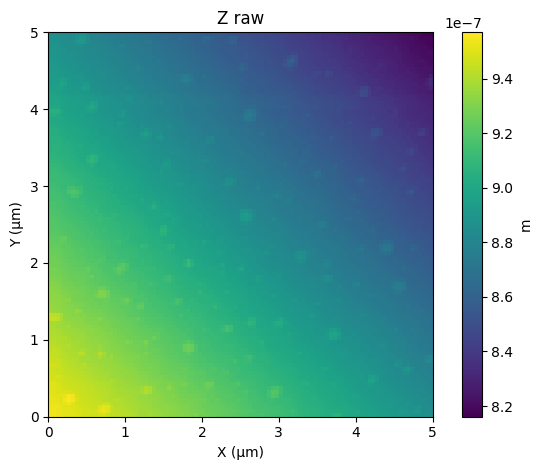

In [5]:
z = imgs.get("Z raw")  # or imgs.get("R-Z raw") if you want the rotated one

if z is None:
    # small helper if you're not sure about the exact title
    z = next((img for k, img in imgs.items() if k.lower() == "z raw"), None)

if z:
    z.plot(title=z.meta["title"])


# Spectra

## Visualize all NF spectra

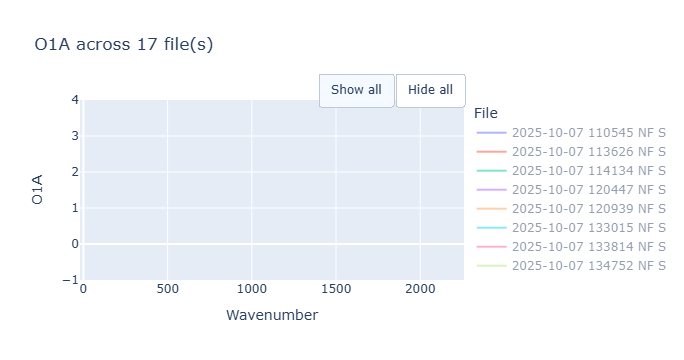

In [6]:
#import re
#MY_RE = re.compile(r"(?i)\bNF[\s\u00A0_-]*S.*\.txt$")  # e.g., accept extra suffixes before .txt

fig = plot_channel_for_folder_plotly(
    folder="../",
    channel="O1A",
    xcol="Wavenumber",
    recursive=True,
    eps=0.0,
    start_hidden=True,
    regex=NF_S_RE,   # default; can be omitted
)
fig.show()


## Load a single NF spectrum

In [7]:
# 1) Load a NEASPEC spectrum (your TXT with header + tabular data)
spec_file = os.path.join(data_path,"2025-10-07 164131 NF S.txt")

spec: Spectrum = load_neaspec_spectrum(
    spec_file   # ← change to your file path
)

# 2) Use it
df = spec.df            # pandas DataFrame with the spectral table
header = spec.header    # dict with parsed header (meta + parameters)

#print(df.head())        # first rows
print(header["meta"])   # key metadata (Scan, Project, Date, etc.)


{'Source': 'www.neaspec.com', 'Scan': 'Fourier Scan', 'Project': '20251007_PS', 'Description': [], 'Date': '10/07/2025 16:41:31', 'Reference': '10/07/2025 16:26:38', 'Laser Source': '4.5-15 µm nano-FTIR laser', 'Detector': 'R', 'Version': '2.1.11536.0', '_filename': '2025-10-07 164131 NF S.txt'}


## Visualize the loaded spectrum with selected channels

In [8]:
fig1 = df_plot_plotly(spec.df, x="Wavenumber", y=["O1A", "O2A"], eps=0.0, title="O1A/O2A",window=False)
fig1.show()

In [9]:
plot_channel_dropdown(spec.df, xcol="Wavenumber", window=True, start_hidden=True)

# Identify peaks

In [10]:
channel = "O2A"

In [11]:
peaks = detect_peaks(spec.df, xcol="Wavenumber", ycol=channel, prominence=0.02, distance=5)
peaks_df = peaks.peaks
peaks_df

,x,y,prominence,height,left_x,right_x,fwhm_x,index
0,6.250000,0.032880,0.034165,0.032880,1.880421,15.581204,13.700783,3
1,1250.000000,0.226249,0.025663,0.226249,1248.384506,1253.035407,4.650901,600
2,1266.666667,0.238887,0.081536,0.238887,1247.150026,1274.283298,27.133273,608
3,1427.083333,0.253013,0.074722,0.253013,1406.715265,1451.428280,44.713015,685
4,1720.833333,0.402775,0.423562,0.402775,1516.583192,1739.615592,223.032399,826
5,1931.250000,0.263099,0.027415,0.263099,1924.049737,1936.706129,12.656392,927
6,1972.916667,0.273205,0.136353,0.273205,1804.803359,1978.399386,173.596027,947


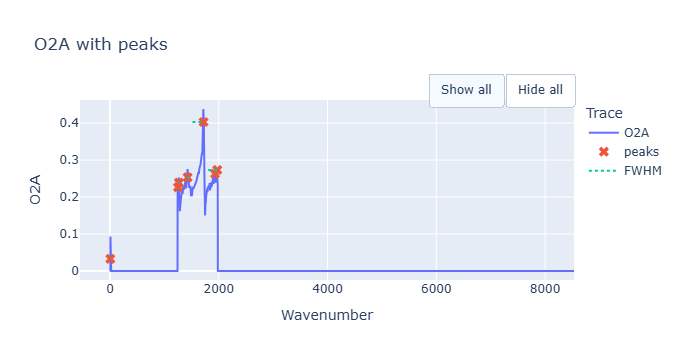

In [12]:
fig = plot_spectrum_with_peaks(spec.df, peaks_df, xcol="Wavenumber", ycol=channel,window=False)
fig.show()

# Match peaks

In [13]:
from nanoftirtools.match import load_library_csv, match_peaks_to_library, ReferenceEntry

lib = load_library_csv(os.path.join(db_path,"example_library.csv"))

# 3) Match (e.g., ±5 cm^-1 tolerance)
mr = match_peaks_to_library(peaks, lib, tol=10.0, sort_by="f1")
print(mr.table.head())

# Inspect which peaks matched for the top hit
top = mr.table.iloc[0]["name"]
print("Top:", top)
print("Matched pairs (query, ref, |Δ|):", mr.matches_by_ref[top][:10])


   name  hits  precision    recall        f1  mean_abs_delta  ref_peaks  \
0  PMMA     1   0.142857  0.166667  0.153846        9.166667          6   

   query_peaks  
0            7  
Top: PMMA
Matched pairs (query, ref, |Δ|): [(np.float64(1720.8333333333333), np.float64(1730.0), np.float64(9.166666666666742))]


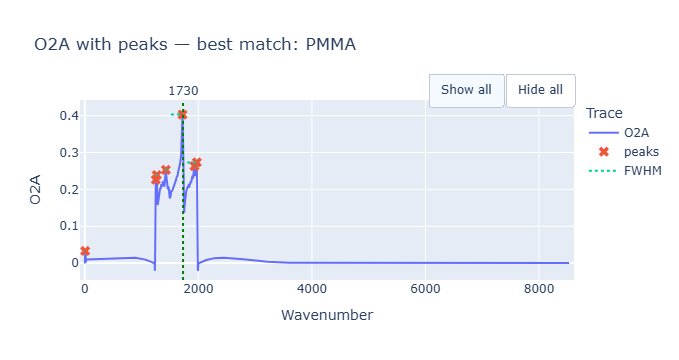

In [14]:
# Plot your corrected spectrum + detected peaks
fig = plot_spectrum_with_peaks(
    spec.df.assign(**{channel: peaks.y_corrected}),
    peaks.peaks,
    xcol="Wavenumber", ycol=channel,
    title=f"{channel} with peaks — best match: {top}",
    window=True
)

# Overlay vertical lines at reference peaks of the top hit
top_pairs = mr.matches_by_ref[top]
matched_ref_peaks = [r for _, r, _ in top_pairs]

for r in matched_ref_peaks:
    fig.add_vline(x=r, line=dict(color="green", dash="dot"), annotation_text=f"{r:.0f}", annotation_position="top")

fig.show()


# Working with several spectra

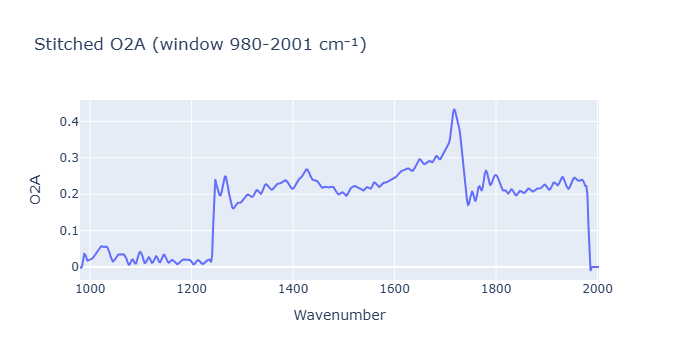

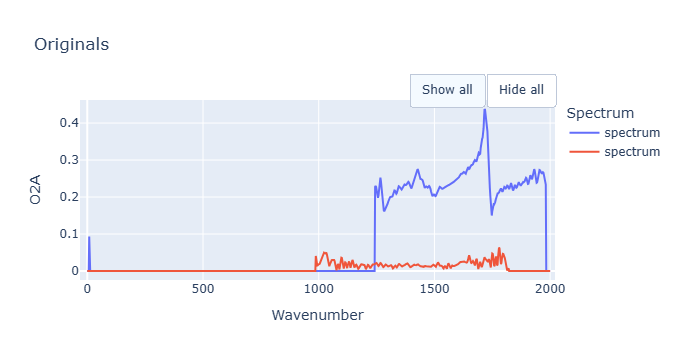

In [15]:
from nanoftirtools.multispec import load_many_from_folder, plot_many_specs, stitch_spectra

spectra = ["2025-10-07 164131 NF S.txt", "2025-10-07 165945 NF S.txt"]
channel = "O2A"

# 1) Load several spectra from a folder (matches "*NF S.txt" incl. NBSP)
specs = load_many_from_folder(
    folder="./data",
    filenames=spectra
)

rep = stitch_spectra(specs, channel=channel,
                     smooth="savgol", smooth_window=5, smooth_polyorder=3,
                     preferred=0,prefer_weight=0.9)

#1) Explicit window 800–2000 cm⁻¹
rep = stitch_spectra(specs, channel=channel,
                     x_window=(980, 2001),
                     smooth="savgol", smooth_window=5, smooth_polyorder=3,
                     preferred=0,prefer_weight=0.9)

# 2) Auto window = UNION of non-zero regions across spectra
#rep = stitch_spectra(specs, channel=channel,
#                    auto_window=True, window_mode="union", eps=0.0,
#                    smooth="savgol", smooth_window=15, smooth_polyorder=3)

# 3) Auto window = INTERSECTION (only where *all* have non-zero data)
#rep3 = stitch_spectra(specs, channel=channel,
                      #auto_window=True, window_mode="intersection", eps=0.0)

# Plot stitched result
import plotly.express as px
px.line(rep.stitched, x="Wavenumber", y=channel,
        title=f"Stitched {channel} (window {rep.x_window[0]:.0f}-{rep.x_window[1]:.0f} cm⁻¹)").show()

# Optional: overlay originals
fig = plot_many_specs(specs, channel=channel, title="Originals", window=True, start_hidden=False)
fig.show()

In [16]:
res = detect_peaks(rep.stitched, xcol="Wavenumber", ycol=channel,
                   use_baseline=True, baseline_method="asls",
                   baseline_kwargs={"lam": 1e7, "p": 0.001})

In [17]:
from nanoftirtools.match import load_library_csv, match_peaks_to_library, ReferenceEntry

lib = load_library_csv(os.path.join(db_path,"example_library.csv"))

# 3) Match (e.g., ±5 cm^-1 tolerance)
mr = match_peaks_to_library(res, lib, tol=10.0, sort_by="f1")
print(mr.table.head())

# Inspect which peaks matched for the top hit
top = mr.table.iloc[0]["name"]
print("Top:", top)
print("Matched pairs (query, ref, |Δ|):", mr.matches_by_ref[top][:10])

          name  hits  precision    recall        f1  mean_abs_delta  \
0         PMMA     4   0.108108  0.666667  0.186047          1.8125   
1  Polystyrene     2   0.054054  0.333333  0.093023          1.8750   

   ref_peaks  query_peaks  
0          6           37  
1          6           37  
Top: PMMA
Matched pairs (query, ref, |Δ|): [(np.float64(992.4999999999995), np.float64(987.0), np.float64(5.499999999999545)), (np.float64(1061.249999999997), np.float64(1061.0), np.float64(0.24999999999704414)), (np.float64(1146.6666666666606), np.float64(1148.0), np.float64(1.3333333333393966)), (np.float64(1384.166666666652), np.float64(1384.0), np.float64(0.16666666665196317))]


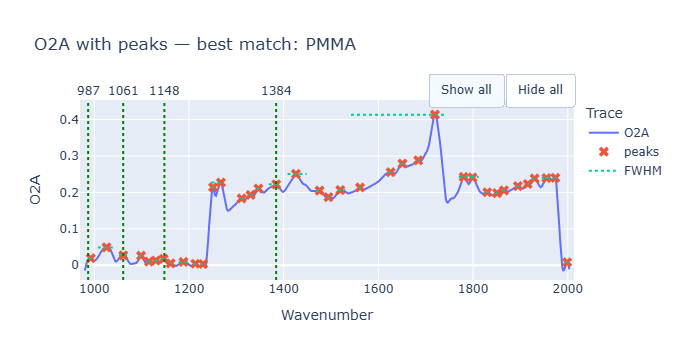

In [18]:
# Plot your corrected spectrum + detected peaks
fig = plot_spectrum_with_peaks(
    rep.stitched.assign(**{channel: res.y_corrected}),
    res.peaks,
    xcol="Wavenumber", ycol=channel,
    title=f"{channel} with peaks — best match: {top}",
    window=True
)

# Overlay vertical lines at reference peaks of the top hit
top_pairs = mr.matches_by_ref[top]
matched_ref_peaks = [r for _, r, _ in top_pairs]

for r in matched_ref_peaks:
    fig.add_vline(x=r, line=dict(color="green", dash="dot"), annotation_text=f"{r:.0f}", annotation_position="top")

fig.show()

# Show position of spectrum

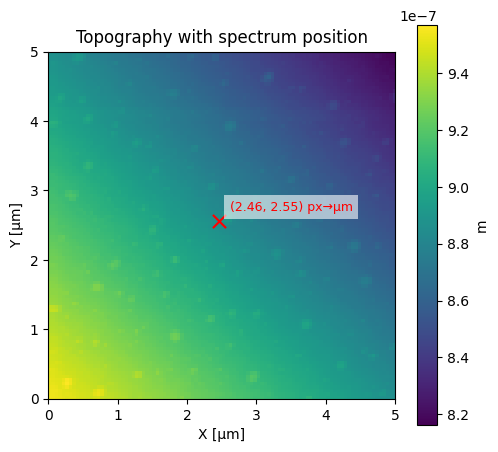

In [19]:
from nanoftirtools.plotting import plot_afm_with_spectrum_marker

plot_afm_with_spectrum_marker(
    imgs["Z raw"]  , spec,
    title="Topography with spectrum position",
    marker_color="r", marker_symbol="x", marker_size=90
)
plt.show()
